In [104]:
#System stuff
import os
import sys
import time
from pathlib import Path
from datetime import datetime

from PIL import Image
from tqdm import tqdm
import gc

# Base Jupyter libraries
import pandas as pd
import numpy as np
import random

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#image handling
import tifffile as tiff
from skimage.transform import resize
from scipy import ndimage

#Keras and Tensorflow
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# trying to solve performance issues on MacOS
# Enable Mixed Precision for macOS Performance
print(f"TensorFlow version: {tf.__version__}")
print("Configuring to optimise performance for macOS...")
# Check if we're on macOS with Metal support
import platform
is_macos = platform.system() == "Darwin"
print(f"Running on macOS: {is_macos}")
# Enable mixed precision policy
from tensorflow.keras import mixed_precision
# Set mixed precision policy - but it may be causing instability, so disable for now
#policy = mixed_precision.Policy('mixed_float16')
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

print(f"Mixed precision policy set to: {policy}")
print(f"Compute dtype: {policy.compute_dtype}")  # float16
print(f"Variable dtype: {policy.variable_dtype}")  # float32

# Verify GPU/Metal availability
print(f"Physical devices: {tf.config.list_physical_devices()}")
if tf.config.list_physical_devices('GPU'):
    print("GPU/Metal acceleration available")
else:
    print("No GPU/Metal detected - mixed precision will still help with CPU")

# Sklearn
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# paths
# Detect environment
KAGGLE_ENV = os.path.exists('/kaggle/input')

if KAGGLE_ENV:
    print("Using Kaggle competition data")
    DATA_DIR = Path('/kaggle/input/histopathologic-cancer-detection')
else:
    print("Running locally with downloaded Kaggle data")
    DATA_DIR = Path("histopathologic-cancer-detection")

TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
LABELS_CSV = DATA_DIR / "train_labels.csv"
OUTPUT_DIR = Path("./outputs")

# Ensure output dir exists
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Plotting defaults
sns.set_theme(context="notebook", style="darkgrid", palette="deep")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})
# helper function to delimit sections in data output
def section_split(width=200, char="-"):
    print("\n", char * width, "\n")

# helper function to save figures
def save_figure(name=None, dpi=300, bbox_inches='tight', pad_inches=0.1):
    # Create directory if it doesn't exist
    save_dir = "figs/5511_module3"
    os.makedirs(save_dir, exist_ok=True)
    # Generate filename
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"chart_{timestamp}.png"
    else:
        # Clean the name to be filename-safe
        filename = "".join(c for c in name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        filename = filename.replace(' ', '_')
        if not filename.endswith('.png'):
            filename += '.png'
    # Full path
    filepath = os.path.join(save_dir, filename)
    # Save the figure
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)
    print(f"Figure saved: {filepath}")
    return filepath

def tif_exists(dir_path, image_id):
    p = Path(dir_path) / f"{image_id}.tif"
    return p.exists()

print("Python:", sys.version.split()[0])

TensorFlow version: 2.16.2
Configuring to optimise performance for macOS...
Running on macOS: True
Mixed precision policy set to: <DTypePolicy "float32">
Compute dtype: float32
Variable dtype: float32
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU/Metal acceleration available
Running locally with downloaded Kaggle data
Python: 3.11.13


## Introduction

### Kaggle Competition Background - The Problem Statement

https://www.kaggle.com/c/histopathologic-cancer-detection/overview

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. Submissions are evaluated on **area under the ROC curve** between the predicted probability and the observed target. For each id in the test set, you must predict a probability that **centre 32x32px region of a patch contains at least one pixel of tumor tissue**. The file should contain a header and follow the format of "sample_submission.csv".

### Project Guidelines

As a mini-project to complete as a weekly assignment, we don't expect you to iterate over your project until you have a model capable of winning the challenge. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project. The grades are more based on the quality and depth of the analysis, not just on a better Kaggle score.

- Deliverable 1 — A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion.
- Deliverable 2 — A public project GitHub repository with your work (please also include the GitHub repo URL in your notebook/report).
- Deliverable 3 — A screenshot of your position on the Kaggle competition leaderboard for your top-performing model.

#### Data Description

In [42]:
def analyze_directory(directory, extension='tif'):
    """Count files and get min/max file sizes"""
    path = Path(directory)
    if extension:
        files = list(path.glob(f"*.{extension.lstrip('.')}"))
    else:
        files = [f for f in path.iterdir() if f.is_file()]
    if not files:
        return {"count": 0, "min_size": 0, "max_size": 0}

    file_sizes = [f.stat().st_size for f in files]

    stats = {
        "count": len(files),
        "min_size": min(file_sizes),
        "max_size": max(file_sizes)
    }
    print(f"In {directory}")
    print(f"number of TIFF files =  {stats['count']}, Min size: {stats['min_size']:,} bytes, Max size: {stats['max_size']:,} bytes")

    return stats

print("-"*60)
print("DATA DESCRIPTION")
print("Image data is stored in two directories: train and test")
stats_train = analyze_directory(TRAIN_DIR, "tif")
stats_test = analyze_directory(TEST_DIR, "tif")
train_labels = pd.read_csv(LABELS_CSV)
print("-"*60)
print("Binary training labels are provided in a csv file")
print("train_labels.csv contains {:,} unique image ids".format(len(train_labels.id.unique())))
missing = [i for i in train_labels.id.values if not tif_exists(TRAIN_DIR, i)]
print(f"Missing train TIF files: {len(missing)}")
print("Check for duplicates = ", train_labels.duplicated().sum())
labels = train_labels['label'].value_counts(normalize=True)
print("Positive labels: {:.2%}".format(labels[1]))
print("Negative labels: {:.2%}".format(labels[0]))
display(train_labels.head())
print("-"*60)

------------------------------------------------------------
DATA DESCRIPTION
Image data is stored in two directories: train and test
In histopathologic-cancer-detection/train
number of TIFF files =  220025, Min size: 27,935 bytes, Max size: 27,935 bytes
In histopathologic-cancer-detection/test
number of TIFF files =  57458, Min size: 27,935 bytes, Max size: 27,935 bytes
------------------------------------------------------------
Binary training labels are provided in a csv file
train_labels.csv contains 220,025 unique image ids
Missing train TIF files: 0
Check for duplicates =  0
Positive labels: 40.50%
Negative labels: 59.50%


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

------------------------------------------------------------


## Exploratory Data Analysis
The problem concerns **histopathologic cancer detection**, so in addition to basic stats, let's look at a few visualizations to get a sense of the data.  An example citation from literature gives an indication of what we might be looking for:
 _"In the visual context, malignant tumors tend to have large and irregular nuclei or multiple nuclear structures. The cytoplasm also undergoes changes, wherein new structures appear, or normal structures disappear. Malignant cells have a small cytoplasmic amount, frequently with vacuoles. In this scenario, the ratio of cytoplasm to nucleus decreases..."_

Following a quick search on the topic (ref: citations), previous Kaggle Submissions and AI recommendations, the following stats and visualizations are common and may prove helpful:
1. **Image consistency checks** - shapes, dtypes, value ranges
2. **Class-specific visual patterns** - intensity and color distributions (maybe different channels have more information?)
3. **Texture analysis** - cancer often shows texture differences (apparently, I am no domain expert)
4. **Sample positive and negative images** - Allow a visual check of what the charts are telling us about the distributions
5. **Train-test similarity** - Quick check that train and test sets seem similar by looking at image mean and standard deviation

Ideally, this will reveal systematic differences between positive and negative cases that could inform the modeling approach and preprocessing decisions.

In [43]:
# Start by creating samples of image ids
sample_size = 50

# for when we want to compare test and train cases
train_ids = train_labels.id.sample(sample_size, random_state=SEED).tolist()
# different because no test_labels-df to consult for ids
test_ids = [file.stem for file in TEST_DIR.glob("*.tif")][:sample_size]

# For when we want to compare positive and negative cases
pos_ids = train_labels[train_labels.label == 1].id.sample(sample_size, random_state=SEED).tolist()
neg_ids = train_labels[train_labels.label == 0].id.sample(sample_size, random_state=SEED).tolist()

In [44]:
def image_consistency_checks(ids, directory = TRAIN_DIR, sample_size=100):

    properties = {
        'shapes': [],
        'dtypes': [],
        'channels': [],
        'pixel_value_ranges': [],
        'mean_intensities': [],
        'std_intensities': []
    }
    for idx, img_id in enumerate(ids[:sample_size]):
        p = directory / f"{img_id}.tif"
        img = tiff.imread(p)
        properties['shapes'].append(img.shape)
        properties['dtypes'].append(str(img.dtype))
        properties['channels'].append(len(img.shape))  # 2D vs 3D
        properties['pixel_value_ranges'].append((img.min(), img.max()))
        properties['mean_intensities'].append(img.mean())
        properties['std_intensities'].append(img.std())

    return pd.DataFrame(properties)

# Analyze both datasets
train_props = image_consistency_checks(train_ids, TRAIN_DIR)
test_props = image_consistency_checks(test_ids, TEST_DIR)
display(train_props.head(10))
display(test_props.head(10))

shapes dtypes  channels pixel_value_ranges  mean_intensities  \
0  (96, 96, 3)  uint8         3           (31, 96)         45.370334   
1  (96, 96, 3)  uint8         3           (0, 255)        131.004196   
2  (96, 96, 3)  uint8         3           (0, 255)        146.208550   
3  (96, 96, 3)  uint8         3           (0, 255)        156.657407   
4  (96, 96, 3)  uint8         3           (0, 255)        137.181641   
5  (96, 96, 3)  uint8         3           (0, 255)        161.527488   
6  (96, 96, 3)  uint8         3           (0, 255)        212.299117   
7  (96, 96, 3)  uint8         3          (29, 255)        239.024812   
8  (96, 96, 3)  uint8         3           (0, 255)        191.064236   
9  (96, 96, 3)  uint8         3           (0, 255)        128.166196   

   std_intensities  
0         8.917805  
1        57.923640  
2        62.690939  
3        61.852155  
4        51.485265  
5        61.452103  
6        49.001738  
7        23.853007  
8        43.807063  
9        52.112288

shapes dtypes  channels pixel_value_ranges  mean_intensities  \
0  (96, 96, 3)  uint8         3           (0, 255)        159.102358   
1  (96, 96, 3)  uint8         3           (0, 255)        187.873915   
2  (96, 96, 3)  uint8         3           (0, 255)        145.284578   
3  (96, 96, 3)  uint8         3           (0, 255)        145.538484   
4  (96, 96, 3)  uint8         3           (0, 255)        128.099971   
5  (96, 96, 3)  uint8         3           (0, 255)        130.562102   
6  (96, 96, 3)  uint8         3           (0, 255)        184.814055   
7  (96, 96, 3)  uint8         3           (0, 255)        127.813187   
8  (96, 96, 3)  uint8         3           (0, 255)        161.577402   
9  (96, 96, 3)  uint8         3           (0, 255)        164.657154   

   std_intensities  
0        53.199516  
1        48.939153  
2        56.523173  
3        63.536247  
4        56.527757  
5        53.807598  
6        49.662134  
7        64.982629  
8        56.619618  
9        52.404039

In [45]:
## Functions for the various plots needed in EDA
## 1) Intensity distributions
## 2) Color channels
## 3) Texture analysis
## 4) Train-test similarity
## 5) Grid of images

def plot_intensity_distributions(pos_ids, neg_ids, sample_size=20,fig_filename="intensity_distributions.png"):
    """Compare pixel intensity distributions between classes"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Sample images from each class
    pos_intensities = []
    neg_intensities = []

    for img_id in pos_ids[:sample_size]:
        img = tiff.imread(TRAIN_DIR / f"{img_id}.tif")
        pos_intensities.extend(img.flatten())

    for img_id in neg_ids[:sample_size]:
        img = tiff.imread(TRAIN_DIR / f"{img_id}.tif")
        neg_intensities.extend(img.flatten())

    # Plot histograms
    axes[0].hist(pos_intensities, bins=50, alpha=0.5, label='Positive')
    axes[0].set_title('Positive Cases - Pixel Intensity')

    axes[1].hist(neg_intensities, bins=50, alpha=0.5, label='Negative', color=sns.color_palette("deep")[1])
    axes[1].set_title('Negative Cases - Pixel Intensity')

    # Overlay comparison
    axes[2].hist(pos_intensities, bins=50, alpha=0.5, label='Positive')
    axes[2].hist(neg_intensities, bins=50, alpha=0.5, label='Negative')
    axes[2].legend()
    axes[2].set_title('Intensity Distribution Comparison')

    plt.tight_layout()
    save_figure(fig_filename)
    plt.show()

def analyze_color_channels(pos_ids, neg_ids, sample_size=50, fig_filename="color_channels.png"):
    """Analyze RGB channel distributions"""

    def get_channel_stats(ids, sample_size):
        r_means, g_means, b_means = [], [], []

        for img_id in ids[:sample_size]:
            img = tiff.imread(TRAIN_DIR / f"{img_id}.tif")
            if len(img.shape) == 3:
                r_means.append(img[:,:,0].mean())
                g_means.append(img[:,:,1].mean())
                b_means.append(img[:,:,2].mean())

        return r_means, g_means, b_means

    pos_r, pos_g, pos_b = get_channel_stats(pos_ids, sample_size)
    neg_r, neg_g, neg_b = get_channel_stats(neg_ids, sample_size)

    # Plot channel comparisons
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    channels = ['Red', 'Green', 'Blue']
    pos_channels = [pos_r, pos_g, pos_b]
    neg_channels = [neg_r, neg_g, neg_b]

    for i, (channel, pos_vals, neg_vals) in enumerate(zip(channels, pos_channels, neg_channels)):
        axes[i].hist(pos_vals, alpha=0.5, label='Positive', bins=20)
        axes[i].hist(neg_vals, alpha=0.5, label='Negative', bins=20)
        axes[i].set_title(f'{channel} Channel Mean Intensity')
        axes[i].legend()

    plt.tight_layout()
    save_figure(fig_filename)
    plt.show()

def texture_analysis(pos_ids, neg_ids, sample_size=50, fig_filename="texture_analysis.png"):
    """Basic texture analysis using variance and gradients"""

    def calculate_texture_features(img_ids, sample_size):
        variances, gradients = [], []

        for img_id in img_ids[:sample_size]:
            img = tiff.imread(TRAIN_DIR / f"{img_id}.tif")

            # Convert to grayscale if needed
            if len(img.shape) == 3:
                gray = np.mean(img, axis=2)
            else:
                gray = img

            # Variance (measure of texture roughness)
            variances.append(np.var(gray))

            # Gradient magnitude (edge information)
            grad_x = ndimage.sobel(gray, axis=0)
            grad_y = ndimage.sobel(gray, axis=1)
            gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
            gradients.append(np.mean(gradient_magnitude))

        return variances, gradients

    pos_var, pos_grad = calculate_texture_features(pos_ids, sample_size)
    neg_var, neg_grad = calculate_texture_features(neg_ids, sample_size)

    # Plot texture comparisons
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].scatter(pos_var, pos_grad, alpha=0.6, label='Positive', s=50)
    axes[0].scatter(neg_var, neg_grad, alpha=0.6, label='Negative', s=50)
    axes[0].set_xlabel('Variance (Texture Roughness)')
    axes[0].set_ylabel('Mean Gradient (Edge Information)')
    axes[0].set_title('Texture Feature Space')
    axes[0].legend()

    # Box plots
    axes[1].boxplot([pos_var, neg_var], tick_labels=['Positive', 'Negative'])
    axes[1].set_title('Texture Variance by Class')
    axes[1].set_ylabel('Variance')

    plt.tight_layout()
    save_figure(fig_filename)
    plt.show()

def compare_train_test_distributions(train_ids, test_ids, sample_size=100, fig_filename="train_test_distributions.png"):
    """Compare distributions between train and test sets"""

    def get_image_stats(ids, directory, sample_size):
        means, stds = [], []
        for img_id in ids[:sample_size]:
            img = tiff.imread(directory / f"{img_id}.tif")
            means.append(img.mean())
            stds.append(img.std())
        return means, stds

    train_means, train_stds = get_image_stats(train_ids, directory = TRAIN_DIR, sample_size=sample_size)
    test_means, test_stds = get_image_stats(test_ids, directory = TEST_DIR, sample_size=sample_size)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].hist(train_means, alpha=0.5, label='Train', bins=20)
    axes[0].hist(test_means, alpha=0.5, label='Test', bins=20)
    axes[0].set_title('Mean Intensity Distribution')
    axes[0].legend()

    axes[1].hist(train_stds, alpha=0.5, label='Train', bins=20)
    axes[1].hist(test_stds, alpha=0.5, label='Test', bins=20)
    axes[1].set_title('Standard Deviation Distribution')
    axes[1].legend()

    plt.tight_layout()
    save_figure(fig_filename)
    plt.show()

# Plot 16 tifs from list of filenames as a grid
def plot_tifs(ids, title):
    plt.figure(figsize=(15,4))
    for idx, img_id in enumerate(ids[:16]):
        p = TRAIN_DIR / f"{img_id}.tif"
        # Already checked for existence above, but to be safe
        if p.exists():
            im = tiff.imread(p)
            ax = plt.subplot(2, 8, idx + 1)
            ax.imshow(im)
            ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    save_figure(f"{title.replace(' ', '_')}.png")
    plt.show()
    return

Figure saved: figs/5511_module3/color_channelspng.png


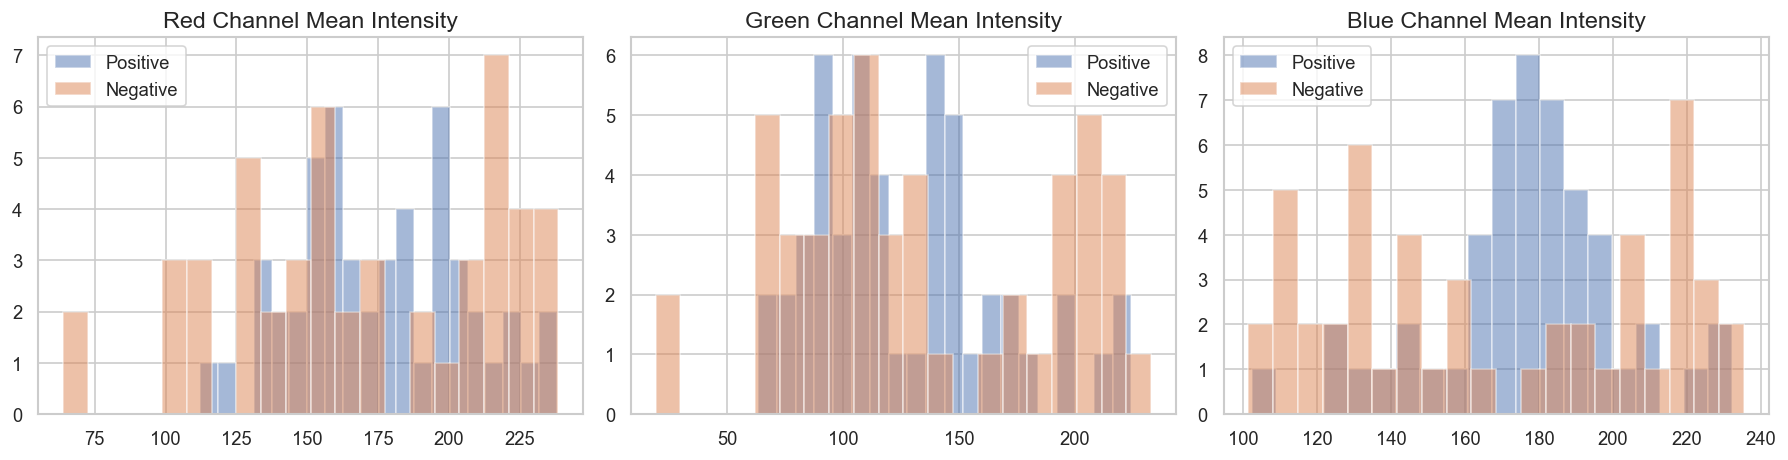

Figure saved: figs/5511_module3/intensity_distributionspng.png


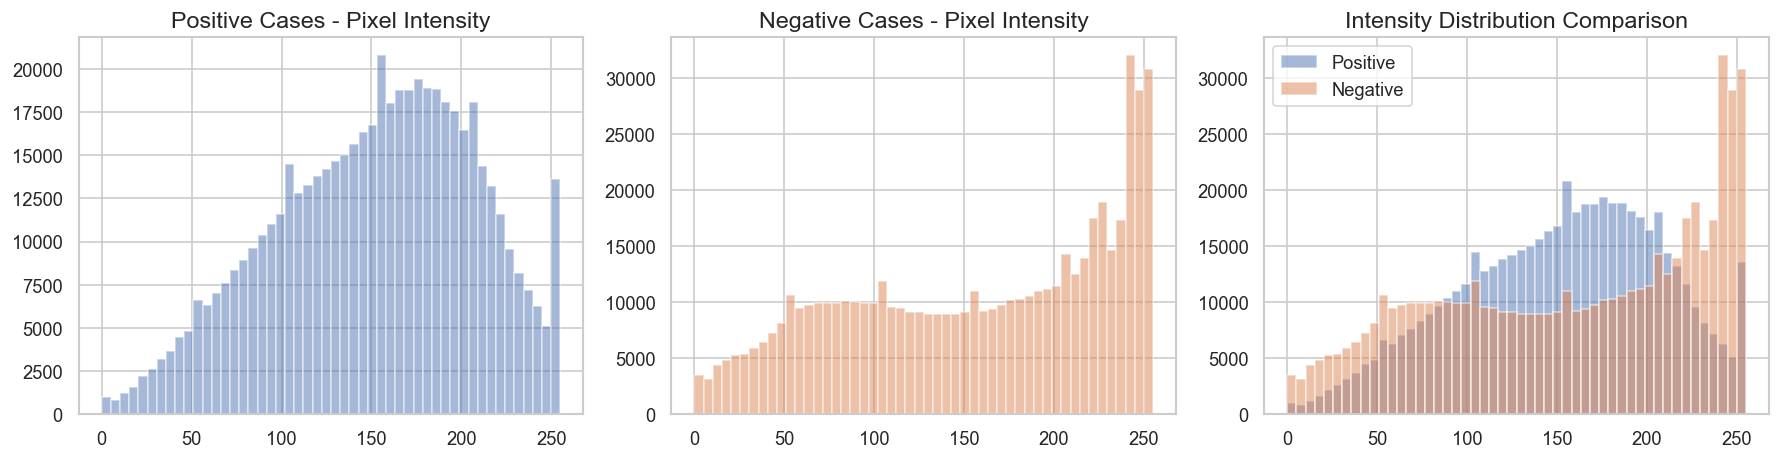

Figure saved: figs/5511_module3/texture_analysispng.png


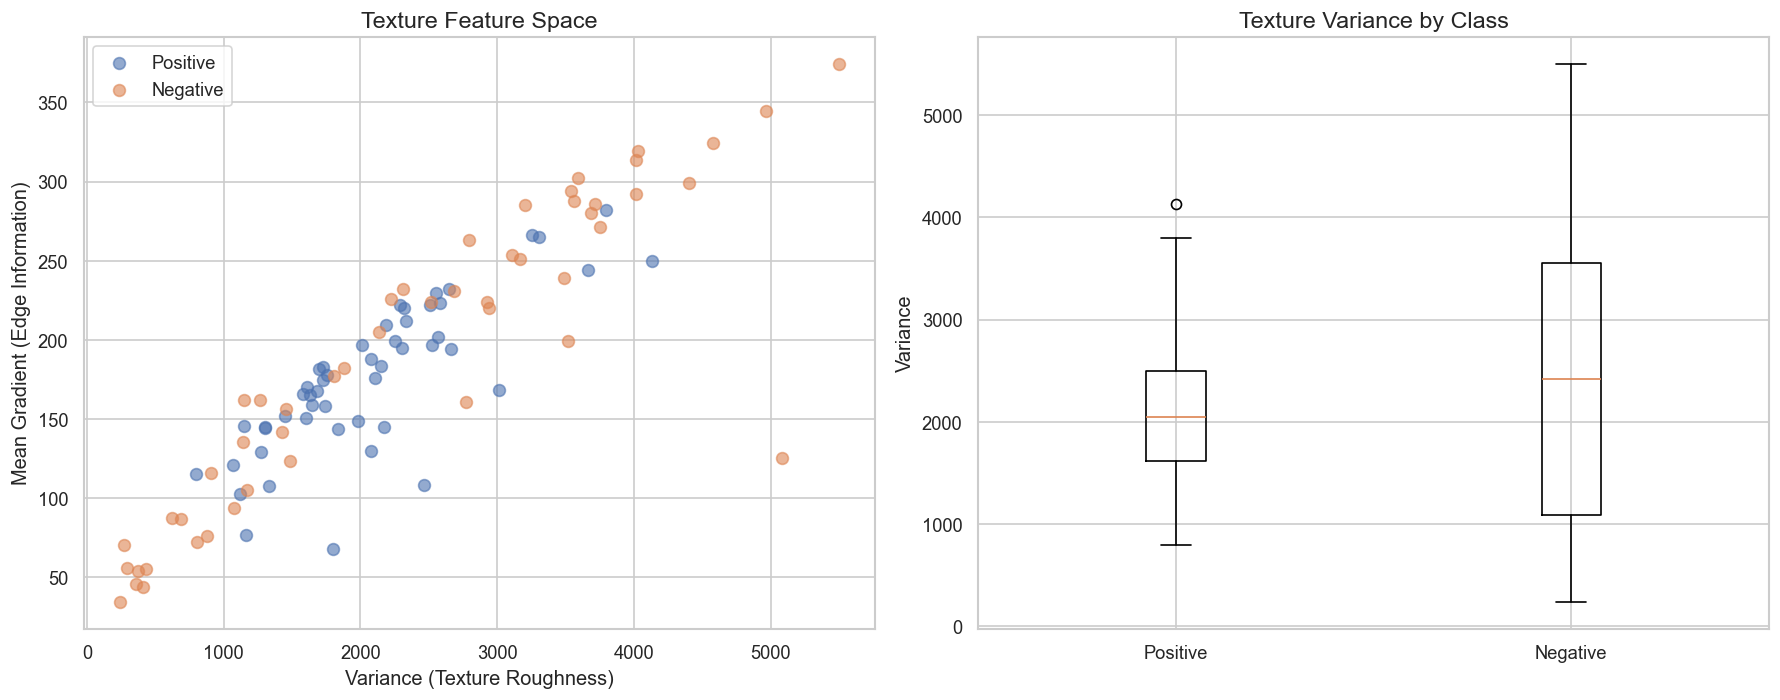

Figure saved: figs/5511_module3/Positive_samples_tifpng.png


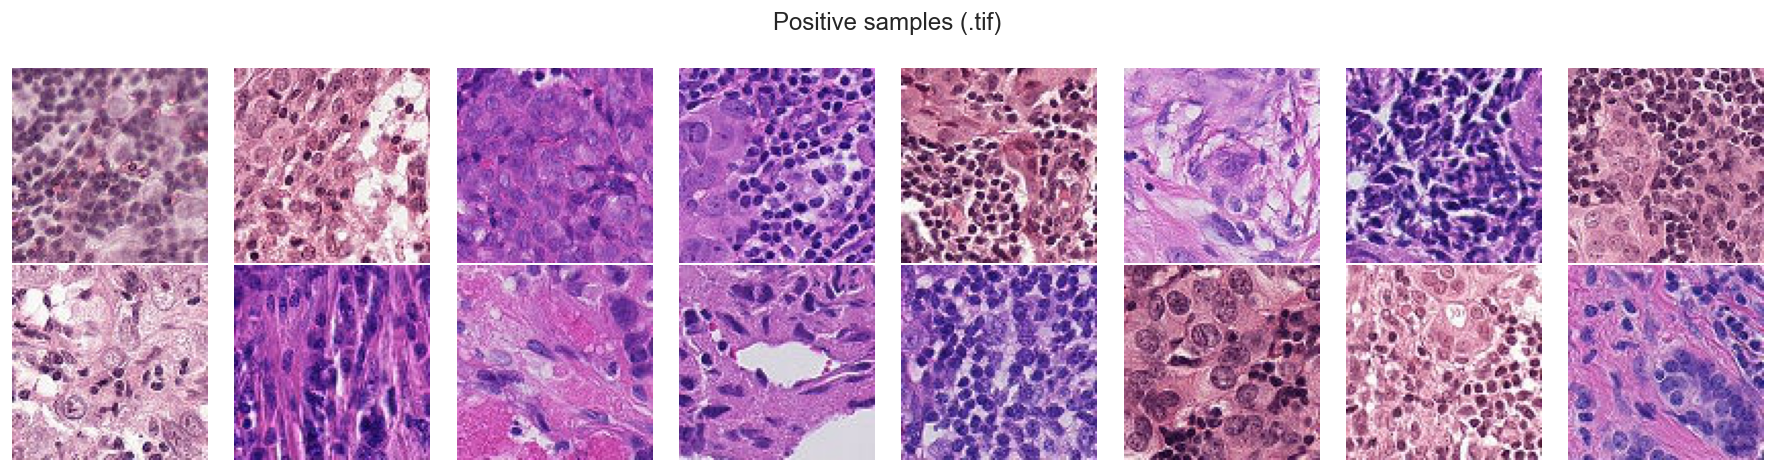

Figure saved: figs/5511_module3/Negative_samples_tifpng.png


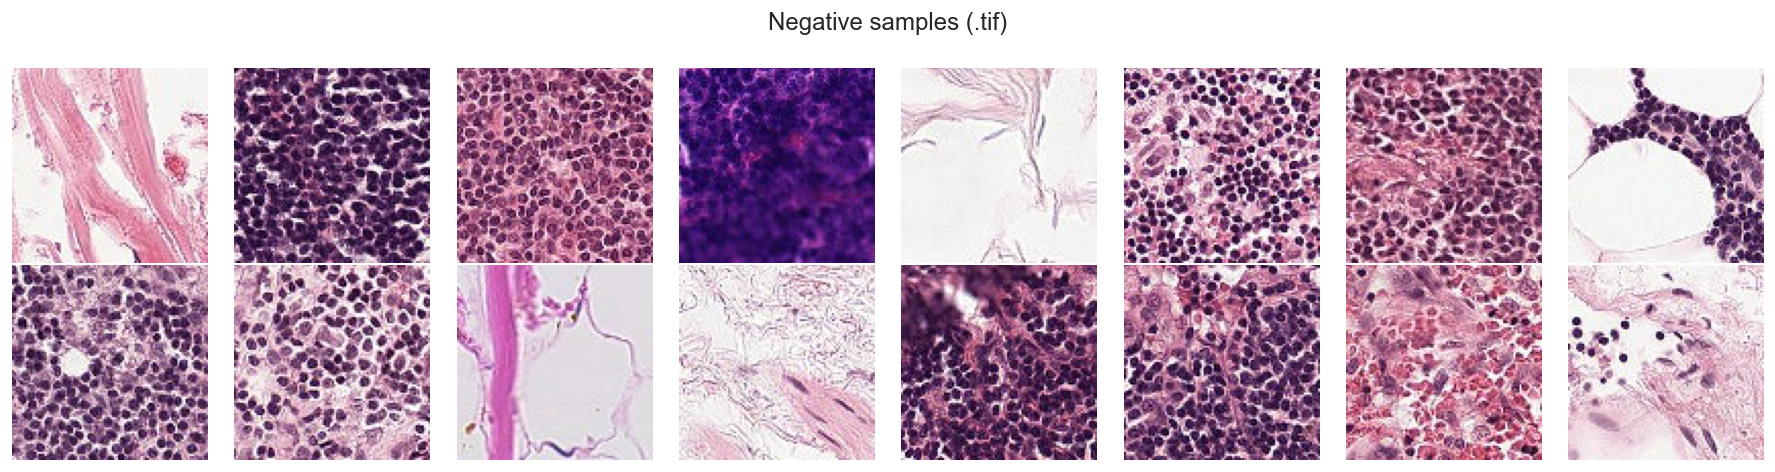

In [46]:
#Analyze intensity distribution
analyze_color_channels(pos_ids, neg_ids)
plot_intensity_distributions(pos_ids, neg_ids)
texture_analysis(pos_ids, neg_ids)
# Plot visual samples
pos_data = plot_tifs(pos_ids, "Positive samples (.tif)")
neg_data = plot_tifs(neg_ids, "Negative samples (.tif)")

Figure saved: figs/5511_module3/train_test_distributionspng.png


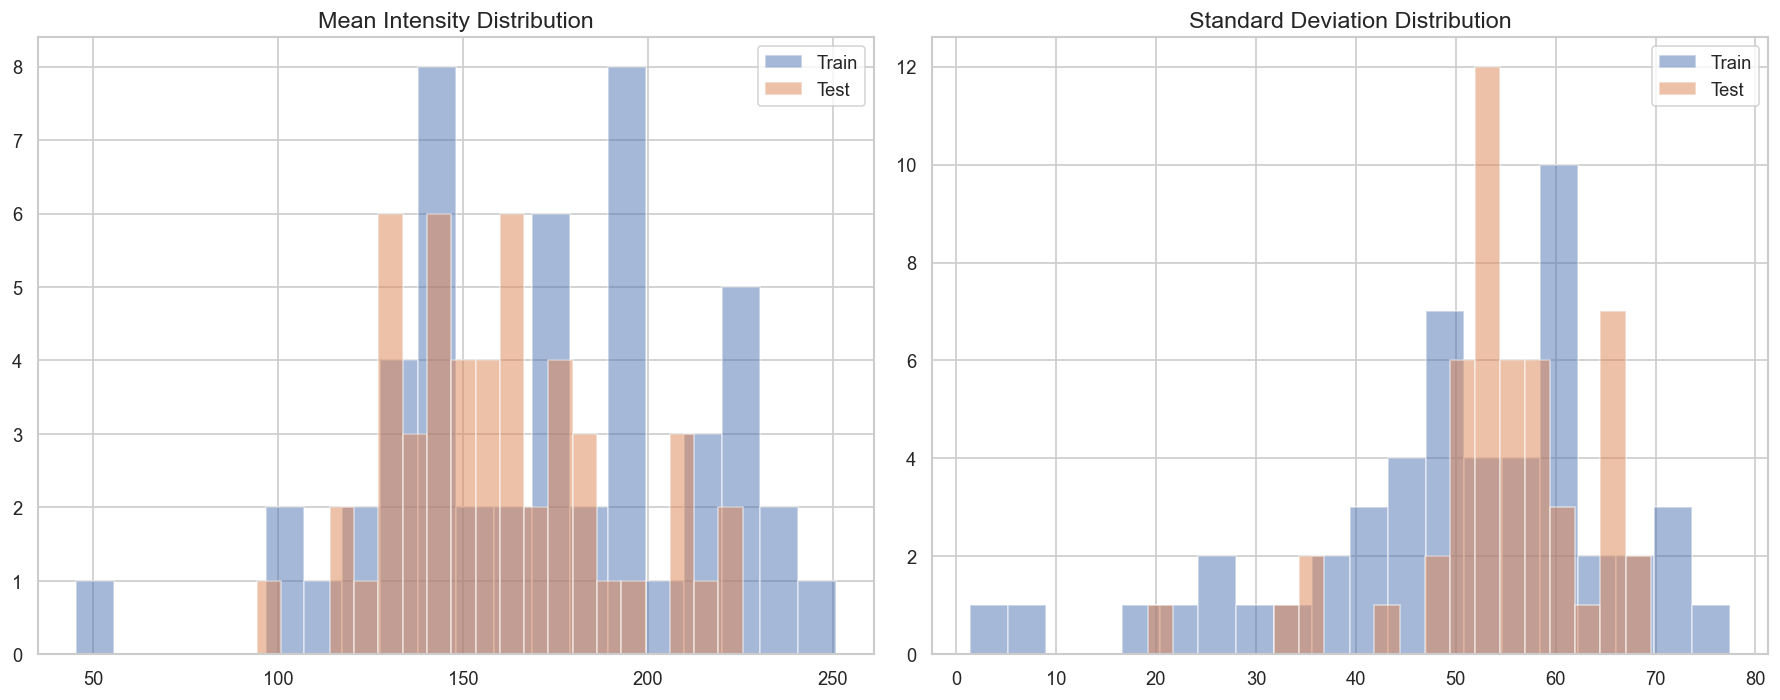

In [47]:
## Check similarity between train and test sets
compare_train_test_distributions(train_ids, test_ids)

### Observations from Initial EDA
1) We have n_samples = 220,025 in the training data
2) Classes are no too unbalanced (positive = 40.5%, negative 59.5%), I will probably anyway use stratified sampling, but it is good to know.
3) No issues with missing files or duplicates,(with same id, haven't checked actual images).
4) Images are in .tif format and seem to have a consistent shape (96,96,3) and dtype = uint8.
5) Images are small and standardised, no doubt to reduce the effort required in the competition setting. Nonetheless, in preprocessing, it may be worth checking (corrupted images, differing sizes, etc.)
5) The colour channel analysis shows that the blue channel may be most helpful in separating positive and negative cases. Positive cases have a tight distribution around blue mean intensity values between 160 and 200.
6) The intensity distributions show more pixels are high intensity (value > 230) for negative cases. Whereas, positive cases have a distribution closer to normal distribution in shape with a peak around intensity = 170
7) The texture analysis shows that positive cases have a wider distribution for variance (texture roughness) than negative cases. (more white areas, higher variation in intensity)
7) Looking at the grid of visual samples: positive cases are visibly bluer, and tend to have less white (high-intensity) area. The features are less distinct (less variation in intensity) than for the negative samples.
9) Happily, the test and train sets seem quite similar.

## Preprocessing

Needs to start by creating a clean tf.data.Dataset based on pre-split train/val sets.
1) Add 'file_paths' column to the train_labels df and split into file_paths and labels
3) scikit-learn train_test_split with stratify=labels
4) Base loader: decode/resize/scale only, note: the competition is asking for 32 x 32 crops from the 96 x 96 center
5) Had to create a function to load the TIFF image using tifffile and convert to tensor (tf doesn't natively support.tif)
5) Branch into train/val pipelines, shuffle train, no shuffle val (shuffle train avoids bias and stabilizes learning. Keep validation deterministic.)
6) Augmentation will be done later in the model training loop.
7) Cache the raw data before any processing

### Sizing

In my initial runs, I cropped to 32 x 32 from the 96 x 96 center and then rescaled to 128 x 128 believing this would help with model input if I selected to use a pretrained model. However, I am going to stick to building my own models from scratch and I am uncertain the cropping is necessary. I am also hoping that avoiding this crop/rescale may help with peformance on the image loading part of the pipeline.

I am leaving the code in the function, but commented out, in case I need to revisit this new assumption.

### TIFF Image Loading

My initial approach was to use a python function to load the TIFF (as per the bullet notes above) and then convert to tensor. However, I found that this was very slow. I was able to speed it up a little by using the tf.py_function but it's slow. Having tried and failed with tfio.image.decode_tiff, I decided to add a pre-processing step to convert the TIFF files into PNG files that tf can use natively. AI Assistant helpful in creating this preprocessing step.

### Blue Channel Only

Based on the EDA results, it seems that the blue channel is the most helpful in separating positive and negative cases. Using a single channel (blue) could improve the model performance.
1) A Strong signal
2) Faster training due to reduced input size (96,96,1) three times smaller than (96,96,3). Note, h & w will be scaled to fit model, but depth will be reduced by a factor of 3.
3) Reduces the number of parameters in the model. (Less memory usage, faster training, reduced risk of overfitting.)

To confirm this hypothesis, I will need to compare the performance of a model with all channels and blue channel only. So preprocessing will need to deliver two datasets.

In [48]:
## TARGET image size needs to be set according to model requirements
## New approach: just keep the 96 x 96 resolution
TARGET = (96, 96)

def convert_tiff_to_png_batch(input_dir, output_dir, target_size=TARGET, channels='rgb', batch_info=""):
    """One-time conversion of TIFF files to PNG with preprocessing"""

    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Get list of TIFF files
    tiff_files = list(input_path.glob("*.tif"))

    if not tiff_files:
        print(f"No TIFF files found in {input_dir}")
        return

    print(f"Converting {len(tiff_files)} TIFF files {batch_info}")
    print(f"From: {input_dir}")
    print(f"To: {output_dir}")
    print(f"Target size: {target_size}, Channels: {channels}")

    successful_conversions = 0
    errors = []

    for tiff_file in tqdm(tiff_files, desc="Converting"):
        try:
            # Load TIFF image
            img = tiff.imread(tiff_file)

            # Ensure we have the expected shape
            if len(img.shape) != 3 or img.shape[2] != 3:
                errors.append(f"{tiff_file.name}: Unexpected shape {img.shape}")
                continue

            # Resize if needed
            if img.shape[:2] != target_size:
                img = resize(img, (*target_size, img.shape[2]), anti_aliasing=True, preserve_range=True)

            # Handle channel selection
            if channels == 'b':
                # Extract blue channel and convert to grayscale PNG
                img = img[:, :, 2]  # blue channel only
                img_uint8 = (img * 255).astype(np.uint8)
                # Save as grayscale
                Image.fromarray(img_uint8, mode='L').save(output_path / f"{tiff_file.stem}.png")
            else:
                # Save RGB
                img_uint8 = (img * 255).astype(np.uint8)
                Image.fromarray(img_uint8).save(output_path / f"{tiff_file.stem}.png")

            successful_conversions += 1

        except Exception as e:
            errors.append(f"{tiff_file.name}: {str(e)}")

    print(f"\nConversion complete!")
    print(f"Successfully converted: {successful_conversions}/{len(tiff_files)} files")

    if errors:
        print(f"Errors encountered: {len(errors)}")
        for error in errors[:5]:  # Show first 5 errors
            print(f"  - {error}")
        if len(errors) > 5:
            print(f"  ... and {len(errors) - 5} more errors")

    return successful_conversions, errors


# Define PNG directories
PNG_TRAIN_RGB_DIR = Path("./preprocessed/train_png_rgb")
PNG_TRAIN_BLUE_DIR = Path("./preprocessed/train_png_blue")
PNG_TEST_RGB_DIR = Path("./preprocessed/test_png_rgb")
PNG_TEST_BLUE_DIR = Path("./preprocessed/test_png_blue")

# Convert training data
print("=" * 60)
print("CONVERTING TRAINING DATA")
print("=" * 60)

if not PNG_TRAIN_RGB_DIR.exists() or len(list(PNG_TRAIN_RGB_DIR.glob("*.png"))) == 0:
    convert_tiff_to_png_batch(TRAIN_DIR, PNG_TRAIN_RGB_DIR, TARGET, channels='rgb', batch_info="(Train RGB)")
else:
    print(f"RGB training PNGs already exist in {PNG_TRAIN_RGB_DIR}")

if not PNG_TRAIN_BLUE_DIR.exists() or len(list(PNG_TRAIN_BLUE_DIR.glob("*.png"))) == 0:
    convert_tiff_to_png_batch(TRAIN_DIR, PNG_TRAIN_BLUE_DIR, TARGET, channels='b', batch_info="(Train Blue)")
else:
    print(f"Blue training PNGs already exist in {PNG_TRAIN_BLUE_DIR}")

# Convert test data
print("\n" + "="*60)
print("CONVERTING TEST DATA")
print("="*60)

if not PNG_TEST_RGB_DIR.exists() or len(list(PNG_TEST_RGB_DIR.glob("*.png"))) == 0:
    convert_tiff_to_png_batch(TEST_DIR, PNG_TEST_RGB_DIR, TARGET, channels='rgb', batch_info="(Test RGB)")
else:
    print(f"RGB test PNGs already exist in {PNG_TEST_RGB_DIR}")

if not PNG_TEST_BLUE_DIR.exists() or len(list(PNG_TEST_BLUE_DIR.glob("*.png"))) == 0:
    convert_tiff_to_png_batch(TEST_DIR, PNG_TEST_BLUE_DIR, TARGET, channels='b', batch_info="(Test Blue)")
else:
    print(f"Blue test PNGs already exist in {PNG_TEST_BLUE_DIR}")

print("\n" + "="*60)
print("CONVERSION SUMMARY")
print("="*60)
print(f"RGB Training PNGs: {len(list(PNG_TRAIN_RGB_DIR.glob('*.png'))) if PNG_TRAIN_RGB_DIR.exists() else 0}")
print(f"Blue Training PNGs: {len(list(PNG_TRAIN_BLUE_DIR.glob('*.png'))) if PNG_TRAIN_BLUE_DIR.exists() else 0}")
print(f"RGB Test PNGs: {len(list(PNG_TEST_RGB_DIR.glob('*.png'))) if PNG_TEST_RGB_DIR.exists() else 0}")
print(f"Blue Test PNGs: {len(list(PNG_TEST_BLUE_DIR.glob('*.png'))) if PNG_TEST_BLUE_DIR.exists() else 0}")


CONVERTING TRAINING DATA
RGB training PNGs already exist in preprocessed/train_png_rgb
Blue training PNGs already exist in preprocessed/train_png_blue

CONVERTING TEST DATA
RGB test PNGs already exist in preprocessed/test_png_rgb
Blue test PNGs already exist in preprocessed/test_png_blue

CONVERSION SUMMARY
RGB Training PNGs: 220025
Blue Training PNGs: 220025
RGB Test PNGs: 57458
Blue Test PNGs: 57458


In [49]:
# Updated fast PNG loading functions
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

def load_png_tf(path, label, channels='rgb'):
    """Fast loading using TensorFlow's native PNG decoder"""
    img = tf.io.read_file(path)
    if channels == 'b':
        img = tf.image.decode_png(img, channels=1)
    else:
        img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_png_dataset(png_dir, img_ids, labels, channels='rgb', training=True):
    """Create dataset from PNG files"""
    file_paths = [str(png_dir / f"{img_id}.png") for img_id in img_ids]

    # Convert to TensorFlow dataset
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    ds = ds.map(lambda p, l: load_png_tf(p, l, channels),
            num_parallel_calls=AUTO, deterministic=False)

    if training:
        ds = ds.shuffle(min(len(file_paths), 1000))

    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE, drop_remainder=training)
    ds = ds.prefetch(AUTO)

    return ds

# Create new fast datasets using PNG files
print("Creating fast PNG-based datasets...")

# 1) Split BEFORE building tf.data
## Add a filepaths column to the train_labels df
train_labels['file_paths'] = train_labels.id.apply(lambda x: str(TRAIN_DIR / f"{x}.tif"))
# split into file_paths and labels
file_paths = train_labels['file_paths']
labels = train_labels['label']
X_tr, X_val, y_tr, y_val = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)

# RGB datasets
train_ds = make_png_dataset(PNG_TRAIN_RGB_DIR, X_tr.apply(lambda x: Path(x).stem), y_tr,
                                channels='rgb', training=True)
val_ds = make_png_dataset(PNG_TRAIN_RGB_DIR, X_val.apply(lambda x: Path(x).stem), y_val,
                              channels='rgb', training=False)

# Blue channel datasets
train_blue = make_png_dataset(PNG_TRAIN_BLUE_DIR, X_tr.apply(lambda x: Path(x).stem), y_tr,
                                  channels='b', training=True)
val_blue = make_png_dataset(PNG_TRAIN_BLUE_DIR, X_val.apply(lambda x: Path(x).stem), y_val,
                                channels='b', training=False)

print("PNG datasets created successfully!")

Creating fast PNG-based datasets...
PNG datasets created successfully!


In [50]:
# helper function to return dataset descriptions from variable names
def dataset_name(dataset_var_name):
    """Get dataset name from variable name"""
    name_mapping = {
        'train_ds': 'Training Dataset (RGB)',
        'val_ds': 'Validation Dataset (RGB)',
        'train_blue': 'Training Dataset (Blue Channel)',
        'val_blue': 'Validation Dataset (Blue Channel)',
        'train_tiny_b': 'Training Dataset (Tiny)',
        'train_small_b': 'Training Dataset (Small)',
        'train_medium_b': 'Training Dataset (Medium)',
        'train_tiny_rgb': 'Training Dataset (Tiny)',
        'train_small_rgb': 'Training Dataset (Small)',
        'train_medium_rgb': 'Training Dataset (Medium)'
    }
    return name_mapping.get(dataset_var_name, 'Unknown Dataset')

In [51]:
# try it out
def test_model_compatibility(dataset, channels_type='rgb', name="Training Dataset"):
    """Test if dataset is compatible with a simple model"""
    start_time = time.time()
    print(f"\n=== Model Compatibility Test for{dataset_name(name)} ===")
    if channels_type == 'b':
        c = 1
    else:
        c = 3

    # Create a simple model to test compatibility
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(*TARGET, c)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    try:
        # Try to fit one batch
        for images, labels in dataset.take(1).cache():
            print(f"  Batch image shape: {images.shape}")
            print(f"  Expected shape: ({BATCH_SIZE}, {TARGET[0]}, {TARGET[1]}, {c})")
            print(f"  Image value range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
            loss = model.train_on_batch(images, labels)
            print(f"✓ Successfully processed one batch")
            print(f"  Loss: {loss[0]:.4f}, Accuracy: {loss[1]:.4f}")
            break
        print("✓ Dataset is compatible with model training!")
        success = True

    except Exception as e:
        print(f"✗ Error processing dataset: {e}")
        success = False

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"⏱️ Execution time: {execution_time:.3f} seconds")

    return success, execution_time

# Test compatibility
_, rgb_time = test_model_compatibility(train_ds, channels_type='rgb',name='train_ds')
_, blue_time = test_model_compatibility(train_blue,channels_type='b',name='train_blue')


=== Model Compatibility Test forTraining Dataset (RGB) ===
  Batch image shape: (64, 96, 96, 3)
  Expected shape: (64, 96, 96, 3)
  Image value range: [0.000, 1.000]


2025-10-06 12:07:30.268619: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


✓ Successfully processed one batch
  Loss: 0.6970, Accuracy: 0.5312
✓ Dataset is compatible with model training!
⏱️ Execution time: 1.481 seconds

=== Model Compatibility Test forTraining Dataset (Blue Channel) ===
  Batch image shape: (64, 96, 96, 1)
  Expected shape: (64, 96, 96, 1)
  Image value range: [0.000, 1.000]


2025-10-06 12:07:31.517043: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


✓ Successfully processed one batch
  Loss: 0.6762, Accuracy: 0.5781
✓ Dataset is compatible with model training!
⏱️ Execution time: 0.949 seconds


### Preprocessing observations
That was painful, principally because I am new to Keras. I discovered and fixed:
- ImageDataGenerator is deprecated, which nearly all the examples I found online or on Kaggle have used
- There is no equivalent to load_from_dataframe, base expectation (one class per directory) is not satisfied either.)
- tf doesn't accept tiff files as input so needed a custom loader using tiffile
- fixing the shape of the images proved critical to avoid performance issues (loading tiff using a py_function wrapper is nasty)
- I experienced problems with strings becoming tensors in the tf pipeline, which needed to be converted back to strings for tiffile.
- Ended up creating (with a lot of help from AI and Google) the functions above to load train and val as tf.data.Datasets
- I had to shuffle the train set to avoid bias and stabilize learning. There still seems to be an issue with the sequence of this shuffle, the caching and subsequent operations (take(1)). Fixeed by commenting out the caching in add_train_ops, not convinced this is really the solution, may need to address later.

NOTE: All of the above bullets are true. In the end, I gave up with this approach, it simply took too long to train any models. The final approach was to split the preprocessing into two steps:
1) Convert TIFF to PNG
2) Create tf.data.Datasets from PNG files

This was many orders of magnitude faster. (For example the trial model used to take roughly 1 minute to train 1 epoch, now it takes 1.5 seconds.)

I note these issues, primarily for my learning and memory when I meet them next time.

### Blue version

Inconclusive, to complete the simple compatibility model for 1 batch:
- Execution speed is 2x the rgb version, but the accuracy metric is typically lower.
- However, the accuracy metric is too unstable to be usable with just one batch.

The speed advantage, may be worth having and I would like to compare the models for rgb vs b performance. So I will keep it for now.

### Sample Datasets

The last step in preprocessing, I will create tiny, small & medium sample datasets to use for different parts of the process. E.g. Tiny when just checking the model, small for hyperparameter tuning, medium for any final checks. Before running on the full dataset.

In [52]:
def create_small_dataset(X_full, y_full, sample_size=1000, test_size=0.2):
    """Create a smaller, balanced dataset for quick experiments"""

    # First, sample a small subset while maintaining class balance
    X_sample, _, y_sample, _ = train_test_split(
        X_full, y_full,
        train_size=sample_size,
        stratify=y_full,
        random_state=42
    )

    # Then split into train/val
    X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
        X_sample, y_sample,
        test_size=test_size,
        stratify=y_sample,
        random_state=42
    )
    return X_train_small, X_val_small, y_train_small, y_val_small

# Define different dataset sizes for different stages
dataset_configs = {
    'tiny': 1000,      # Architecture testing
    'small': 5000,     # Hyperparameter tuning
    'medium': 20000,   # Final validation
    'full': len(X_tr)  # Final training
}

def create_dataset_by_size(size_name='small', channels='b'):
    sample_size = dataset_configs[size_name]

    if sample_size >= len(X_tr):
        # Use full dataset
        X_train, y_train, y_val = X_tr, y_tr #(validation X_val, y_val is unchanged)
    else:
        # Sample subset
        X_train, X_val, y_train, y_val = create_small_dataset(
            X_tr, y_tr, sample_size=sample_size
        )

    train_ds = make_png_dataset(PNG_TRAIN_BLUE_DIR, X_train.apply(lambda x: Path(x).stem), y_train,
                                  channels=channels, training=True)
    val_ds = make_png_dataset(PNG_TRAIN_BLUE_DIR, X_val.apply(lambda x: Path(x).stem), y_val,
                                channels=channels, training=False)

    print(f"Created '{size_name}' dataset: {len(X_train)} training samples")
    return train_ds, val_ds

# Usage for different stages
train_tiny_b, val_tiny_b = create_dataset_by_size('tiny', channels='b')      # Quick architecture tests
train_small_b, val_small_b = create_dataset_by_size('small', channels='b')   # Hyperparameter tuning
train_medium_b, val_medium_b = create_dataset_by_size('medium', channels='b') # Pre-final validation

train_tiny_rgb, val_tiny_rgb = create_dataset_by_size('tiny', channels='rgb')      # Quick architecture tests
train_small_rgb, val_small_rgb = create_dataset_by_size('small', channels='rgb')   # Hyperparameter tuning
train_medium_rgb, val_medium_rgb = create_dataset_by_size('medium', channels='rgb') # Pre-final validation


Created 'tiny' dataset: 800 training samples
Created 'small' dataset: 4000 training samples
Created 'medium' dataset: 16000 training samples
Created 'tiny' dataset: 800 training samples
Created 'small' dataset: 4000 training samples
Created 'medium' dataset: 16000 training samples


## Model Development

### Model Architecture
_Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem._
My primary objective is learning, so I will keep it simple. I'm sure my model won't win any Kaggle competitions, but for now it is more important to me that I understand what I'm doing.

So I will use a simple Sequential model. And, then maybe add a little complexity or try a different architecture.

### Model Tuning
The project asks us to compare models with different architectures and tune hyperparameters.
1) Compare the same model with rgb and blue channel only.
2) I will use one of the pre-trained models from the Keras library (EfficientNetV2B0) and add a few layers to it.

For hyperparameter tuning, I will focus on learning rate, but also try varying the number of epochs (see if it starts over-fitting.
- Learning rate: [0.01, 0.005, 0.001, 0.0005, 0.0001]
- Epochs: 10, 20, 30 - potentially, first I will use 20 and see what happens with a callback for early stopping.
- Loss: binary_crossentropy
- Optimizer: Adam

In [53]:
# Global Variables to handle the differing input shapes
BLUE_SHAPE = (96, 96, 1)
RGB_SHAPE = (96, 96, 3)

# Use a function to define the model, so that we can call it when running multiple experiments.
# For example, to try multiple learning rates

def create_model(shape=BLUE_SHAPE):
    """Create and return model architecture (without compilation)"""
    model = Sequential([
        Input(shape=shape),
        Conv2D(32, (3,3), padding='same'),
        BatchNormalization(),  # Add this
        Activation('relu'),

        Conv2D(32, (3,3), padding='same'),
        BatchNormalization(),  # Add this
        Activation('relu'),

        MaxPooling2D((2,2)),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Check function works as expected
blue_model = create_model(BLUE_SHAPE)
blue_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_23     │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,001 (46.88 KB)

 Trainable params: 11,873 (46.38 KB)

 Non-trainable params: 128 (512.00 B)

In [91]:
# Function to plot charts for Loss and AUC after each experiment
def plot_history(history, fig_filename='history plots'):
    epoch_range = range(1, len(history['loss'])+1)
    # Create DataFrame with all metrics
    df = pd.DataFrame({
        'Epoch': list(epoch_range) * 4,
        'Value': (history['loss'] + history['val_loss'] +
                 history['auc'] + history['val_auc']),
        'Metric': (['Loss'] * len(epoch_range) + ['Loss'] * len(epoch_range) +
                  ['auc'] * len(epoch_range) + ['auc'] * len(epoch_range)),
        'Dataset': (['Training'] * len(epoch_range) + ['Validation'] * len(epoch_range) +
                   ['Training'] * len(epoch_range) + ['Validation'] * len(epoch_range))
    })

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Loss plot
    loss_data = df[df['Metric'] == 'Loss']
    sns.lineplot(data=loss_data, x='Epoch', y='Value', hue='Dataset',
                marker='o', ax=axes[0])
    axes[0].set_title('Loss')
    axes[0].set_ylabel('Loss')

    # AUC plot
    auc_data = df[df['Metric'] == 'auc']
    sns.lineplot(data=auc_data, x='Epoch', y='Value', hue='Dataset',
                marker='o', ax=axes[1])
    axes[1].set_title('AUC')
    axes[1].set_ylabel('AUC')

    plt.tight_layout()
    save_figure(fig_filename)
    plt.show()
    return df

In [105]:

def train_with_learning_rates(model_func, train_ds, val_ds, learning_rates, epochs=10, plot_charts=True, shape=BLUE_SHAPE):
    """
    Train model with different learning rates and track best results

    Args:
        model_func: Function that returns a model (without optimizer)
        train_ds: Training dataset
        val_ds: Validation dataset
        learning_rates: List of learning rates to try
        epochs: Number of epochs per run

    Returns:
        DataFrame with results for each learning rate
    """
    results = []

    for lr in learning_rates:
        print(f"\n{'='*60}")
        print(f"Training with learning rate: {lr}")
        print(f"{'='*60}")

        # Clean up after each run
        tf.keras.backend.clear_session()
        gc.collect()


        # Create fresh model for each learning rate
        model = model_func(shape=shape)

        # Compile with current learning rate
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='auc')]
        )

        # Train model
        history = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            verbose=0
        )

        # Find best epoch (highest validation AUC)
        val_aucs = history.history['val_auc']
        best_epoch = np.argmax(val_aucs) + 1  # +1 because epochs start at 1
        best_val_auc = max(val_aucs)
        best_train_auc = history.history['auc'][best_epoch - 1]
        best_val_loss = history.history['val_loss'][best_epoch - 1]
        best_train_loss = history.history['loss'][best_epoch - 1]

        # Store results
        result = {
            'learning_rate': lr,
            'best_epoch': best_epoch,
            'best_val_auc': best_val_auc,
            'best_train_auc': best_train_auc,
            'best_val_loss': best_val_loss,
            'best_train_loss': best_train_loss,
            'final_val_auc': val_aucs[-1],  # Final epoch performance
            'history': history.history  # Store full history if needed
        }
        results.append(result)

        print(f"Best epoch: {best_epoch}, Best Val AUC: {best_val_auc:.4f}")
        if plot_charts:
            plot_history(history.history,fig_filename=f"lr_{lr}")

    # Convert to DataFrame for easy analysis
    results_df = pd.DataFrame(results)
    return results_df

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        verbose=1,
        patience=15,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'models/best_model.keras',
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    )
]

In [106]:
# Set up variables for running experiments
def run_lr_experiment(train_ds, val_ds, model, shape=BLUE_SHAPE, learning_rates=[0.005, 0.001], epochs=20, plot_charts=False, experiment_name="lr_experiment"):
    print(f"Experiment {experiment_name} started")
    print(f'Cycling through learning rates: {learning_rates}')
    print(f'Maximum epochs = {epochs}, but early stopping will be used to stop early')
    # Run experiments
    results_df = train_with_learning_rates(
        model_func=model,
        shape=shape,
        train_ds=train_ds,  # Use your dataset
        val_ds=val_ds,
        learning_rates=learning_rates,
        epochs=epochs,
        plot_charts=plot_charts
    )
    # Display results sorted by best validation AUC
    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    display(results_df[['learning_rate', 'best_epoch', 'best_val_auc', 'best_train_auc', 'best_val_loss']].sort_values('best_val_auc', ascending=False))
    # Find overall best learning rate
    best_lr_row = results_df.loc[results_df['best_val_auc'].idxmax()]
    print(f"\nBest Learning Rate: {best_lr_row['learning_rate']}")
    print(f"Best Validation AUC: {best_lr_row['best_val_auc']:.4f}")
    print(f"Achieved at Epoch: {best_lr_row['best_epoch']}")
    return results_df

### First Experiment - Try different Learning Rates with Blue Channel Only

In [107]:
# Experiment 1: Training with different learning rates on blue channel only
learning_rates = [0.001, 0.0001, 0.01, 0.00001, 0.005]
epochs = 20
results_blue_small = run_lr_experiment(train_ds=train_small_b,
                                       val_ds=val_small_b,
                                       model=create_model,
                                       shape=BLUE_SHAPE,
                                       learning_rates=learning_rates,
                                       epochs=epochs,
                                       plot_charts=False,
                                       experiment_name="blue_small_lr_experiment"
                                       )

Experiment blue_small_lr_experiment started
Cycling through learning rates: [0.001, 0.0001, 0.01, 1e-05, 0.005]
Maximum epochs = 20, but early stopping will be used to stop early

Training with learning rate: 0.001
Restoring model weights from the end of the best epoch: 20.
Best epoch: 20, Best Val AUC: 0.8345

Training with learning rate: 0.0001
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 15, Best Val AUC: 0.8108

Training with learning rate: 0.01
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 14, Best Val AUC: 0.8261

Training with learning rate: 1e-05
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 12, Best Val AUC: 0.7955

Training with learning rate: 0.005
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 15, Best Val AUC: 0.8319

RESULTS SUMMARY


learning_rate  best_epoch  best_val_auc  best_train_auc  best_val_loss
0        0.00100          20      0.834535        0.846797       0.492705
4        0.00500          15      0.831924        0.845975       0.496759
2        0.01000          14      0.826052        0.835019       0.503425
1        0.00010          15      0.810808        0.803720       0.521394
3        0.00001          12      0.795504        0.707761       0.573437


Best Learning Rate: 0.001
Best Validation AUC: 0.8345
Achieved at Epoch: 20


### Second Experiment - Repeat Learning Rate Experiment with RGB data
This time inspecting the charts

Experiment rgb_small_lr_experiment started
Cycling through learning rates: [0.01, 0.005, 0.001, 0.0001]
Maximum epochs = 20, but early stopping will be used to stop early

Training with learning rate: 0.01
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 15, Best Val AUC: 0.8293
Figure saved: figs/5511_module3/lr_001.png


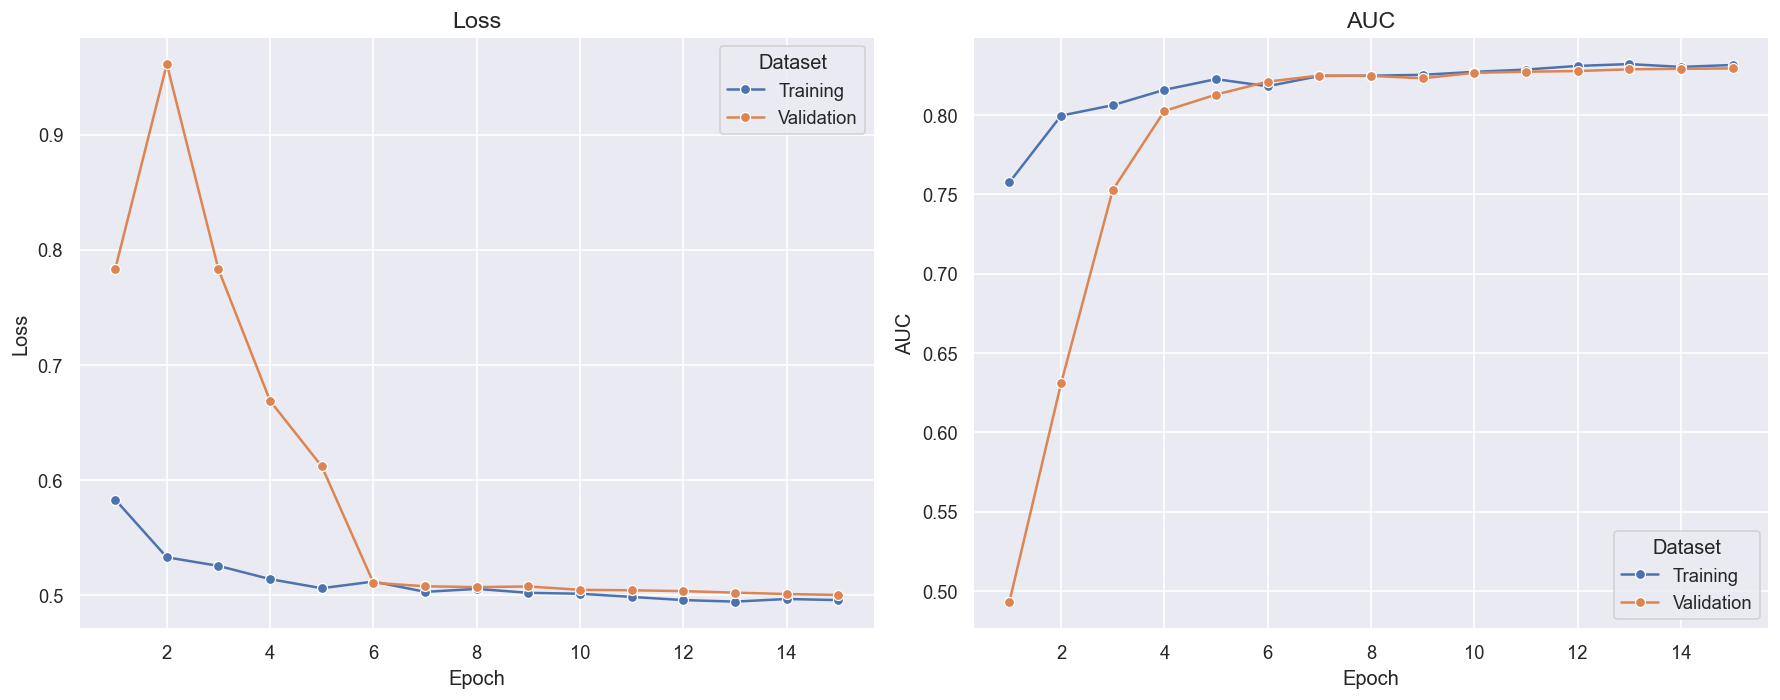


Training with learning rate: 0.005
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 14, Best Val AUC: 0.8319
Figure saved: figs/5511_module3/lr_0005.png


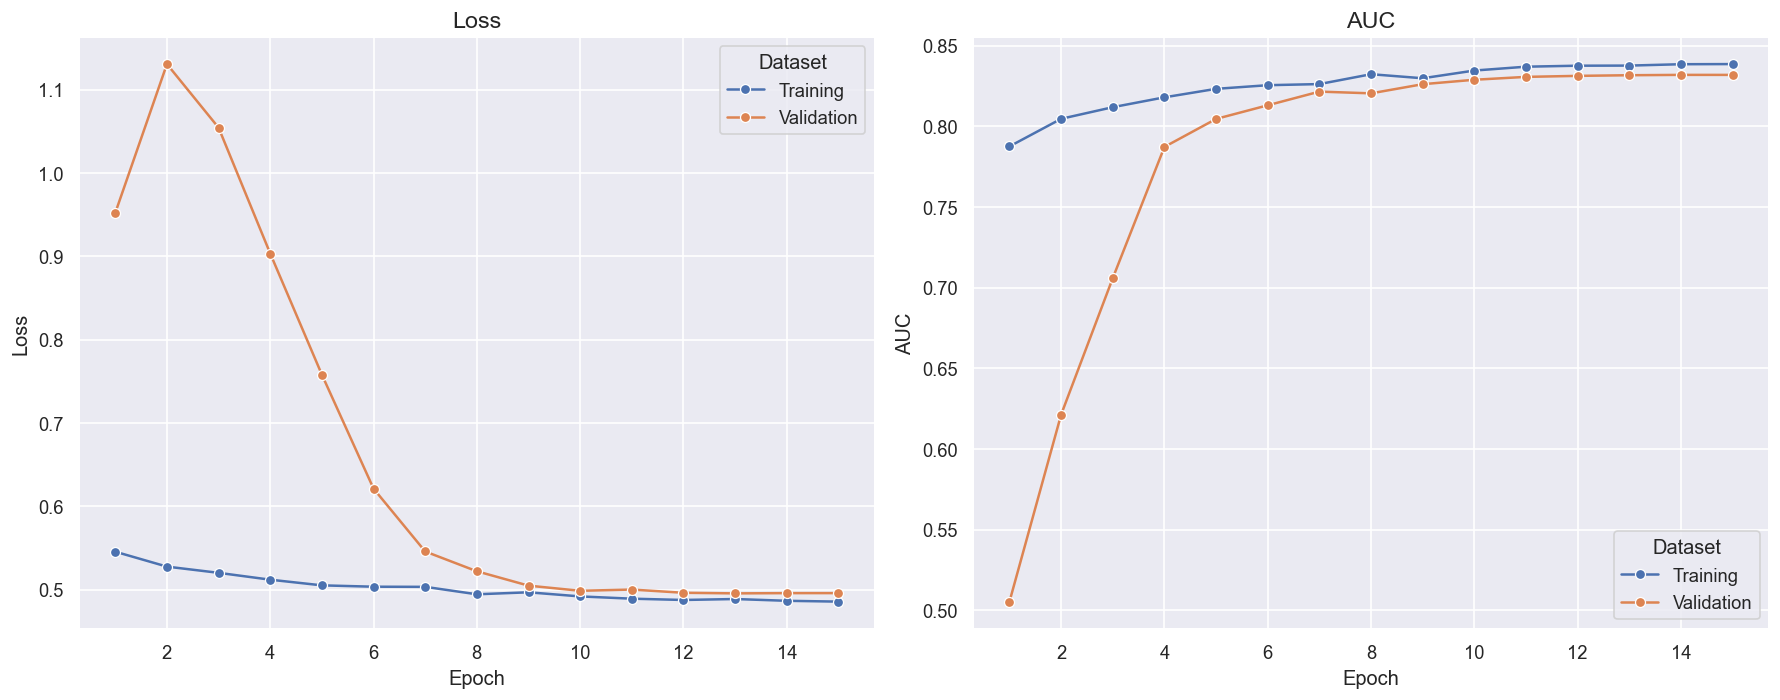


Training with learning rate: 0.001
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 15, Best Val AUC: 0.8309
Figure saved: figs/5511_module3/lr_0001.png


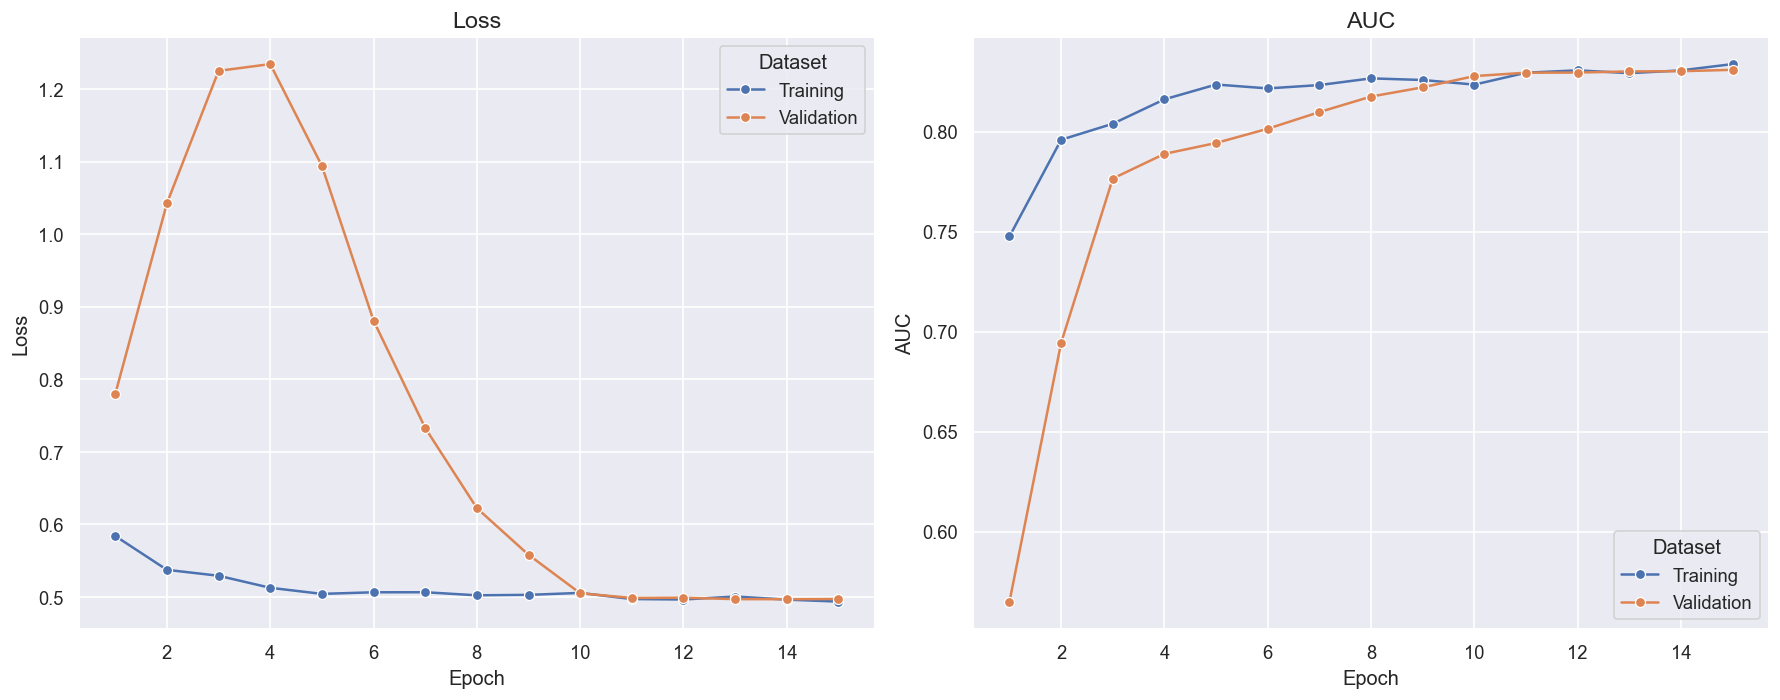


Training with learning rate: 0.0001
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Best epoch: 15, Best Val AUC: 0.8052
Figure saved: figs/5511_module3/lr_00001.png


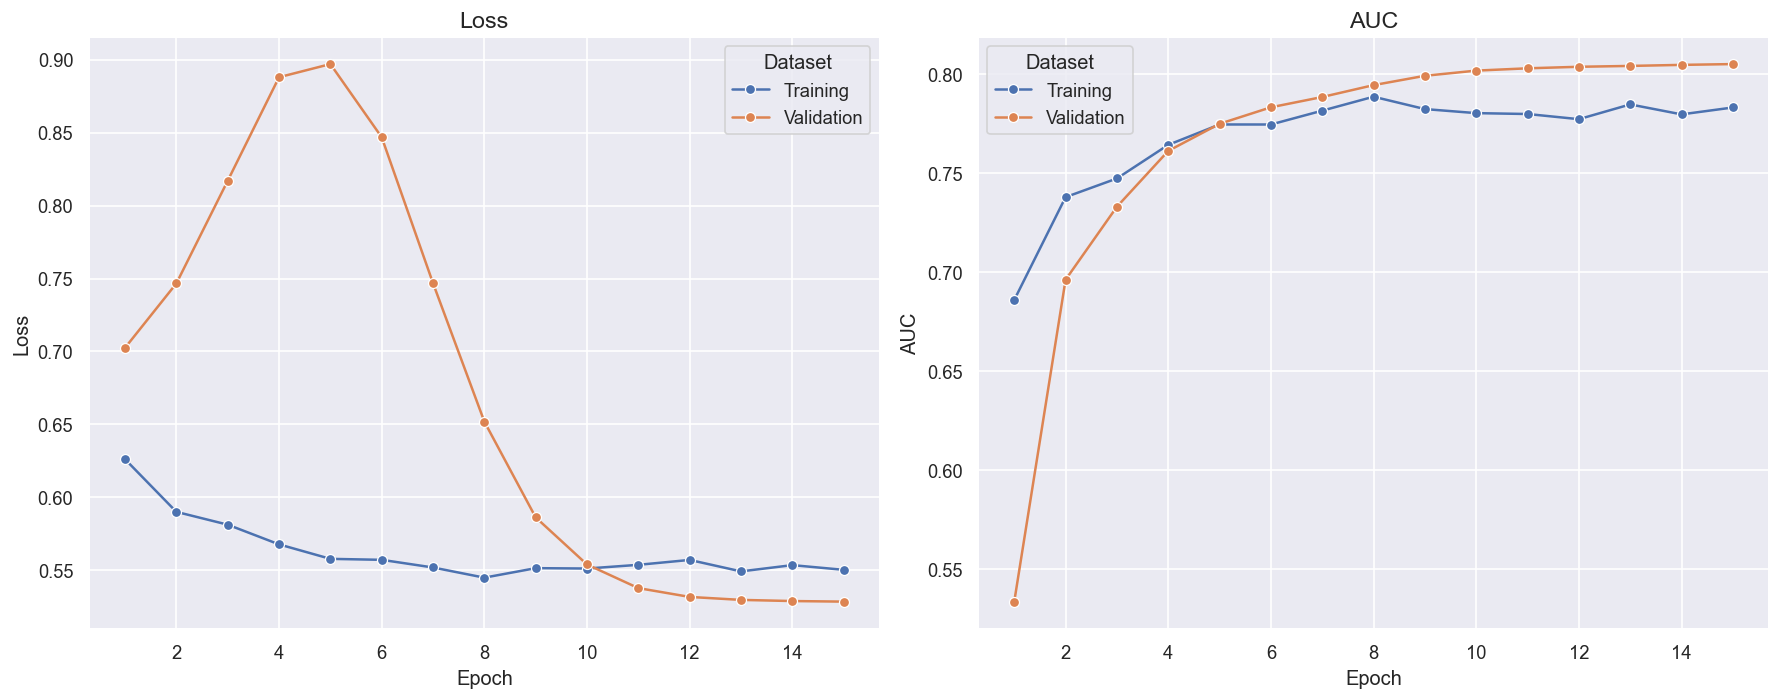


RESULTS SUMMARY


learning_rate  best_epoch  best_val_auc  best_train_auc  best_val_loss
1         0.0050          14      0.831883        0.838487       0.495788
2         0.0010          15      0.830910        0.833782       0.497300
0         0.0100          15      0.829258        0.831435       0.499965
3         0.0001          15      0.805164        0.783225       0.528617


Best Learning Rate: 0.005
Best Validation AUC: 0.8319
Achieved at Epoch: 14


In [108]:
#Reduced set of learning rates based on previous experiment
learning_rates = [0.01, 0.005, 0.001, 0.0001]
epochs = 20
results_rgb_small = run_lr_experiment(train_ds=train_small_rgb,
                                      val_ds=val_small_rgb,
                                      model=create_model,
                                      shape = RGB_SHAPE,
                                      learning_rates=learning_rates,
                                      epochs=epochs,
                                      plot_charts=True,
                                      experiment_name="rgb_small_lr_experiment"
                                      )

### Third Experiment - Use a pretrained model with transfer learning

In [110]:
def create_efficientnet_model(shape=RGB_SHAPE, num_classes=1):
    """EfficientNetV2B0 adapted for smaller input images"""
    inputs = tf.keras.Input(shape=shape)
    # Resize images to match EfficientNet expectations
    x = tf.keras.layers.Resizing(224, 224)(inputs)

    # Load pre-trained EfficientNetV2B0
    base_model = tf.keras.applications.EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

efficient_model = create_efficientnet_model(RGB_SHAPE)
efficient_model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,409 (23.21 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Restoring model weights from the end of the best epoch: 1.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Figure saved: figs/5511_module3/efficient_model_history.png


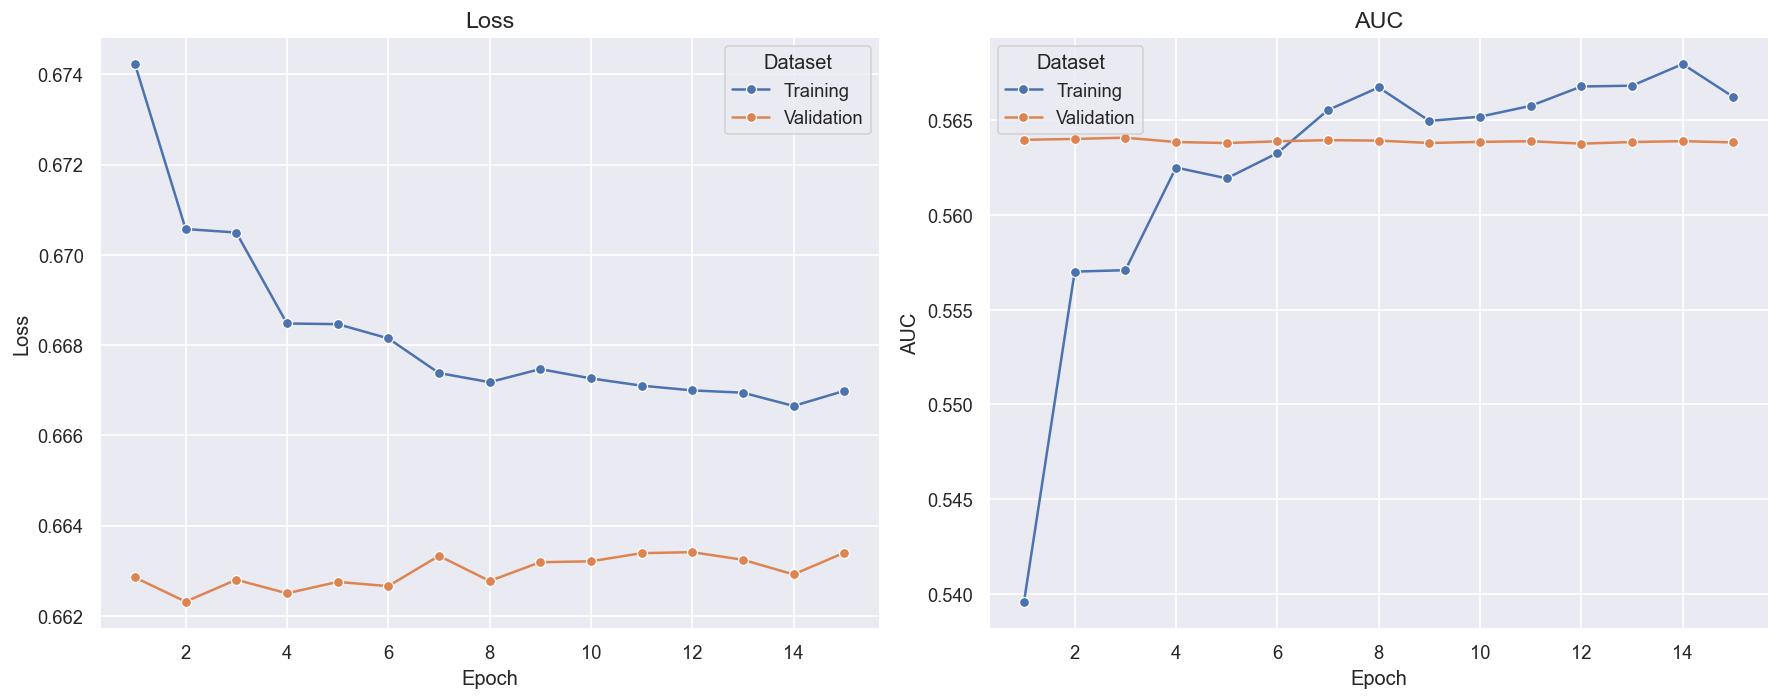

Epoch     Value Metric     Dataset
0       1  0.674228   Loss    Training
1       2  0.670572   Loss    Training
2       3  0.670495   Loss    Training
3       4  0.668478   Loss    Training
4       5  0.668464   Loss    Training
5       6  0.668148   Loss    Training
6       7  0.667380   Loss    Training
7       8  0.667178   Loss    Training
8       9  0.667468   Loss    Training
9      10  0.667261   Loss    Training
10     11  0.667100   Loss    Training
11     12  0.666996   Loss    Training
12     13  0.666945   Loss    Training
13     14  0.666650   Loss    Training
14     15  0.666985   Loss    Training
15      1  0.662849   Loss  Validation
16      2  0.662314   Loss  Validation
17      3  0.662799   Loss  Validation
18      4  0.662498   Loss  Validation
19      5  0.662751   Loss  Validation
20      6  0.662657   Loss  Validation
21      7  0.663329   Loss  Validation
22      8  0.662771   Loss  Validation
23      9  0.663187   Loss  Validation
24     10  0.663207   Loss  Validation
25     11  0.663388   Loss  Validation
26     12  0.663410   Loss  Validation
27     13  0.663241   Loss  Validation
28     14  0.662916   Loss  Validation
29     15  0.663399   Loss  Validation
30      1  0.539591    auc    Training
31      2  0.557015    auc    Training
32      3  0.557091    auc    Training
33      4  0.562511    auc    Training
34      5  0.561940    auc    Training
35      6  0.563273    auc    Training
36      7  0.565548    auc    Training
37      8  0.566741    auc    Training
38      9  0.564973    auc    Training
39     10  0.565196    auc    Training
40     11  0.565768    auc    Training
41     12  0.566790    auc    Training
42     13  0.566832    auc    Training
43     14  0.567973    auc    Training
44     15  0.566237    auc    Training
45      1  0.563975    auc  Validation
46      2  0.564022    auc  Validation
47      3  0.564086    auc  Validation
48      4  0.563858    auc  Validation
49      5  0.563804    auc  Validation
50      6  0.563897    auc  Validation
51      7  0.563957    auc  Validation
52      8  0.563933    auc  Validation
53      9  0.563807    auc  Validation
54     10  0.563866    auc  Validation
55     11  0.563900    auc  Validation
56     12  0.563772    auc  Validation
57     13  0.563857    auc  Validation
58     14  0.563904    auc  Validation
59     15  0.563837    auc  Validation

In [115]:
# Create and compile model with frozen base
efficient_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Train for a few epochs
history1 = efficient_model.fit(
    train_medium_rgb,  # Use RGB dataset
    epochs=10,
    validation_data=val_medium_rgb,
    verbose=0,
    callbacks=callbacks
)

# Unfreeze base model for fine-tuning
efficient_model.layers[1].trainable = True  # base_model is at index 1

# Use lower learning rate for fine-tuning
efficient_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Lower LR
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Fine-tune
history2 = efficient_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    verbose=0,
    callbacks=callbacks
)

plot_history(history2.history, fig_filename="efficient_model_history")

In [116]:
efficient_model.save('models/efficient_final_model.keras')

In [120]:
#Reduced set of learning rates based on previous experiment
final_model = create_model(shape=RGB_SHAPE)
final_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.005, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='auc')]
        )

history = final_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)
final_model.save('models/final_model.keras')

Epoch 1/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 198s 71ms/step - auc: 0.8806 - loss: 0.4237 - val_auc: 0.9033 - val_loss: 0.4251 - learning_rate: 0.0050
Epoch 2/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 194s 70ms/step - auc: 0.8829 - loss: 0.4239 - val_auc: 0.9000 - val_loss: 0.4067 - learning_rate: 0.0050
Epoch 3/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 193s 70ms/step - auc: 0.8816 - loss: 0.4333 - val_auc: 0.8152 - val_loss: 0.6763 - learning_rate: 0.0050
Epoch 4/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 192s 70ms/step - auc: 0.8815 - loss: 0.4395 - val_auc: 0.9200 - val_loss: 0.3917 - learning_rate: 0.0050
Epoch 5/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 191s 70ms/step - auc: 0.8695 - loss: 0.4859 - val_auc: 0.9191 - val_loss: 0.4218 - learning_rate: 0.0050
Epoch 6/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 192s 70ms/step - auc: 0.8637 - loss: 0.5266 - val_auc: 0.9213 - val_loss: 0.4528 - learning_rate: 0.0050
Epoch 7/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 196s 71ms/step - auc: 0.8611 - loss: 0.5597 - val_auc: 0.8964 - val_loss: 0.

## Results and Analysis
Three experiments were run
1) A simple CNN model with blue channel only and varying learning rates)
2) The same model with RGB data
3) A model with EfficientNetV2B0 pre-trained on ImageNet

From these experiments on the small dataset (5000 images):
- The blue channel only model performs best with a learning rate of 0.001 achieving an AUC of 0.834.
- The RGB model performs best with a learning rate of 0.005 achieving an AUC of 0.832.
- The EfficientNetV2B0 model achieved an AUC of 0.833 with a learning rate of 0.005.
- A blue channel model achieves similar performance to what is achieved with all three channels. This seems to confirm the EDA observation that the class separation is much clearer in the blue channel
- Tuning was time-consuming, and I am not satisfied with the results. I found many examples on Kaggle with much higher AUCs. It is not yet clear where the gap is.
- The loss and AUC values do not seem stable in many of the runs, despite my attempts to solve it. It suggests I still have problems with learning rate too high and/or overfitting.


### Generating Competition Submission


In [117]:
# Get test image IDs (since test data has no labels)
test_ids = [file.stem for file in PNG_TEST_RGB_DIR.glob("*.png")]

# Create test dataset (no labels, no shuffling)
# Almost identical to earlier function, will update maybe in next step work
def make_test_dataset(png_dir, img_ids, channels='b'):
    """Create test dataset for predictions"""
    file_paths = [str(png_dir / f"{img_id}.png") for img_id in img_ids]
    # Create dataset with dummy labels
    dummy_labels = [0] * len(file_paths)
    ds = tf.data.Dataset.from_tensor_slices((file_paths, dummy_labels))
    # Load images
    ds = ds.map(lambda p, l: load_png_tf(p, l, channels), num_parallel_calls=AUTO)
    # Just return images, ignore dummy labels
    ds = ds.map(lambda img, label: img)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTO)

    return ds, img_ids

# Create test dataset
test_ds, test_image_ids = make_test_dataset(PNG_TEST_RGB_DIR, test_ids, channels='rgb')

In [121]:
# Get predictions
predictions = final_model.predict(test_ds, verbose=1)
print(f"Predictions shape: {predictions.shape}")
print(f"Sample predictions: {predictions[:5].flatten()}")

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_image_ids,
    'label': predictions.flatten()  # Convert to 1D array
})

# Sort by ID
submission = submission.sort_values('id').reset_index(drop=True)

# Save submission
submission.to_csv('outputs/submission.csv', index=False)

print(f"Submission saved with {len(submission)} predictions")
print("Sample submission:")
print(submission.head())


898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step
Predictions shape: (57458, 1)
Sample predictions: [0.12802513 0.39153662 0.07427592 0.23950465 0.9999089 ]
Submission saved with 57458 predictions
Sample submission:
                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.912244
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.863120
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.527586
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.151099
4  000270442cc15af719583a8172c87cd2bd9c7746  0.030581


## Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

### Personal Learning

This exercise was packed full of firsts for me. The first time that I've used Keras, first time I've processed image, built a CNN, used a pre-trained model or experimented with tuning models this intensely. Although the results are not as good as I would have liked, I am happy with the learning.

Key takeaways for me:
- Think through the pre-processing steps and avoid overcomplicating what is done at the modelling stage. In my initial versions, I ended up building a convoluted algorithm with tiffile and wrapping in a py-function within the TF pipeline. It took a long time to develop and the resulting training even on the smallest datasets was painfully slow. It was more than a 10x performance gain when I split this into a step to convert the images into something tf could handle and then the tf pipeline for loading the Dataset and training.
- Model-tuning, seems to more of an art form than a science. I need to investigate the various libraries more and find ways to practice with smaller challenges.
- There are many performance improvements I rant out of time to try. For example, I read that transforming the input images with random rotation and flipping can improve performance. I will try this in the future.
- I found much simpler notebooks on Kaggle that achieved similar or better results. In this project, I found myself disappearing into complex rabbit holes that took a long time to resolve.

Some positives from what I built:
- I'm pretty happy with the EDA stage: the functions built to generate a strong set of histograms and plots compare well with anything else I found on Kaggle. The resulting insights certainly helped what I then did in the subsequent stages.
- The comparison of blue vs rgb was interesting both in terms of the EDA/results but also in terms of how you set up to compare differing pipelines (differing data sets, differing model inputs,...
- The construction of functions to support learning rate experimentation and results generation were strong
- The struggles with getting performance out of my MacBook Pro setup, mean that I have a much better idea of how to do that for other projects going forward.
- (I'm kicking myself that I did not set up some of the dataset handling and model generation within Classes, that would have made things easier.

In summary: a tremendously tough but fruitful learning experience. I need to keep reminding myself that this was a first attempt and it will get easier with practice.



## Citations

Thatha, V.N., Karthik, M.G., Gaddam, V.G. et al. Histopathological image based breast cancer diagnosis using deep learning and bio inspired optimization. Sci Rep 15, 19034 (2025). https://rdcu.be/eJqBt

Histopathologic Cancer Detection with Hybrid Deep Learning model: https://dl.acm.org/doi/10.1145/3644116.3644199

Cancer diagnosis in histopathological image: CNN based approach: https://www.sciencedirect.com/science/article/pii/S2352914819301133
